# Are We Rich Yet? HW4 version

In [1]:
%matplotlib inline

%run talibref.py

## Q1 EDA and the Baseline Model

The data file here that you read in is a database of reviews, one review per row from the Yelp web site.  The columns are:

* `user_id`: an opaque id for the reviewer
* `business_id`: an opaque id for the restaurant
* `date`: the date the review was made
* `review_id`: on opaque id for the review
* `stars`: the number of stars the user gave it
* `text`: the text of the review
* `business_avg`: the average rating this business got
* `business_review_count`: the number of reviews this business had
* `user_avg`: the average rating this user gave
* `user_review_count`: the number of reviews this user did.

Users rate restaurants on a scale of 1-5. Even though this rating is integer valued, for the purposes of this assignment we shall treat it as a real number.

We start with a 31MB in size data set and create a smaller one to start. The 31MB dataset is already too large for most of the computations in this notebook to complete within a few minutes, so we will need to pare it down.

In [32]:
#df=pd.read_csv("data/IYR.csv")
#df.date = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
#dftouse = df.copy()
#dftouse.tail()

ticker = 'IYZ'
startdate=datetime.date(2009, 1, 1)
enddate=datetime.date.today()
df = generate_ticker_data(ticker, startdate, enddate)
dftouse = df.copy()
dftouse.head()

Available data: Ticker(IYZ) from 2000.05.26 to 2015.11.27
Usable data: Ticker(IYZ) from 2001.03.14 to 2015.11.27 
Returned data: Ticker(IYZ) from 2009.01.02 to 2015.11.27 
Save path: data/IYZ_from_2009.01.02_2015.11.27.csv


,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal
0,2009-01-02,16.590000,17.049999,16.340000,17.000000,191500,16.799999,False,-0.011765,15.700000,False,-0.076471,0,17.014887,16.2155,15.416113,0.990688,9.859542,False,False,False,1,16.492679,19.498276,20.701668,0,0,16.286481,17.823831,17.888191,0,0,15.280000,1,9.795035,24.785122,19.663038,False,True,0,32,1,183.172819,0,0.100592,0.033176,0.067417,1,-0.005952,0,37.034034,1,3.532278,0,58.413733,1,65.340642,1,-2.824804,0,90696.048255,1,95.835932,73.235615,0,100.000000,100.000000,0,-0.318588,0,16.796666,20.943333,16.223332,21.516667,12.076665,25.663334,11.503331,0
1,2009-01-05,16.719999,16.799999,16.440001,16.799999,450700,17.129999,True,0.019643,16.030001,False,-0.045833,0,17.082515,16.2630,15.443485,0.827632,10.078272,False,False,False,1,16.504731,19.462537,20.662845,0,0,16.291986,17.800821,17.874994,0,0,15.315400,1,9.918513,23.348890,18.523617,False,True,0,28,1,123.540742,0,0.140365,0.054614,0.085752,1,-0.166423,0,36.911348,1,4.412672,0,56.286210,1,66.634350,1,-14.124302,0,282627.449178,1,90.166994,85.827476,0,79.812357,93.270786,0,-0.302988,0,16.680000,20.709999,15.989998,21.400001,11.959999,25.430000,11.269997,0
2,2009-01-06,16.980000,17.200001,16.790001,17.129999,662400,16.889999,False,-0.014011,16.299999,False,-0.048453,0,17.203151,16.3010,15.398849,0.959457,11.068655,False,False,False,1,16.529251,19.431643,20.627693,0,0,16.303562,17.786643,17.865406,0,0,15.350092,1,10.641207,26.591463,17.714263,False,True,0,20,1,169.642030,0,0.196252,0.082941,0.113311,1,-0.012625,0,45.684792,1,5.480289,0,58.943320,1,71.323459,0,-4.321108,0,474244.945173,1,91.565550,92.522825,0,100.000000,93.270786,0,-0.286544,0,17.040000,21.430001,16.710000,21.760001,12.319999,26.150002,11.989999,0
3,2009-01-07,16.790001,17.129999,16.740000,16.889999,219600,17.459999,True,0.033748,16.080000,False,-0.047957,0,17.175349,16.2940,15.412651,0.838118,10.818076,False,False,False,1,16.543398,19.397979,20.590502,0,0,16.313408,17.766881,17.852688,0,0,15.424088,1,11.202651,25.452256,17.504622,False,True,0,20,1,117.565957,0,0.218656,0.110084,0.108572,1,0.312151,1,37.529342,1,6.026359,0,56.264712,1,66.417197,0,-19.135914,0,493396.047943,1,84.298183,88.676909,0,43.076747,74.296368,0,-0.269891,0,16.919999,19.989999,16.469998,20.440000,13.399998,23.510000,12.949997,0
4,2009-01-08,16.709999,17.490000,16.709999,17.459999,464100,17.110001,False,-0.020046,16.469999,False,-0.056701,0,17.331858,16.3300,15.328142,1.063952,12.270151,False,True,False,1,16.579343,19.372310,20.559352,0,0,16.336386,17.759871,17.848124,0,0,15.495125,1,12.249067,27.201099,16.025859,False,True,0,64,1,138.281342,0,0.279187,0.143905,0.135282,1,0.393575,1,40.692428,1,10.716544,0,60.818793,1,71.626268,0,-1.570733,0,592685.130645,1,89.097527,88.320420,0,100.000000,81.025582,0,-0.252281,0,17.219999,19.619999,16.949999,19.889999,14.549999,22.289999,14.279999,0


In [33]:
dftouse.tail()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal
1734,2015-11-20,29.860001,29.900000,29.639999,29.680000,153400,29.629999,False,-0.001685,62.43750,True,1.103689,0,30.489814,29.7270,28.964186,0.469193,5.132129,False,False,False,0,29.162897,29.227979,29.312981,1,0,29.013116,29.253619,29.432630,1,0,28.890592,1,16.913323,25.572952,20.355045,False,True,1,52,1,17.310571,1,0.163693,0.224167,-0.060474,0,-0.167344,0,58.479730,0,-1.066667,0,54.495110,1,54.499672,0,-51.428571,1,385091.955069,1,88.577258,80.148257,0,72.755132,90.918377,0,0.062966,1,29.740000,31.510000,28.899999,32.350001,27.129999,34.120001,26.289998,0
1735,2015-11-23,29.690001,29.840000,29.580000,29.629999,288200,29.760000,True,0.004387,62.46875,True,1.108294,0,30.481659,29.7185,28.955341,0.442017,5.135921,False,False,False,0,29.181215,29.233304,29.316135,1,0,29.022509,29.256816,29.433652,1,0,28.951157,1,16.326191,24.382011,20.481786,False,True,1,48,1,17.048184,1,0.155769,0.210487,-0.054719,0,-0.385339,0,43.285668,0,-0.470275,0,53.636401,1,53.670164,0,-54.285771,1,284944.334474,1,77.700214,82.962588,0,49.788373,74.181168,0,0.064829,1,29.683333,31.396667,28.786666,32.293334,27.073332,34.006668,26.176665,0
1736,2015-11-24,29.549999,29.809999,29.420000,29.760000,558700,29.670000,False,-0.003024,62.00000,True,1.083333,0,30.485201,29.7370,28.988799,0.515370,5.032123,False,False,False,0,29.203912,29.240280,29.320552,1,0,29.032014,29.261284,29.435428,1,0,29.008087,1,15.281278,22.676114,21.919152,False,True,1,44,1,26.554818,1,0.158155,0.200021,-0.041866,0,-0.575353,0,41.692550,0,0.642543,0,55.595551,1,62.117478,0,-32.116838,1,350258.214409,1,73.218502,79.831991,0,77.479020,66.674175,0,0.066542,1,29.663333,31.356667,28.746666,32.273334,27.053332,33.966668,26.136665,0
1737,2015-11-25,29.770000,29.770000,29.590000,29.670000,351900,29.780001,True,0.003707,63.06250,True,1.125463,0,30.449752,29.7170,28.984248,0.467929,4.931532,False,False,False,0,29.222190,29.245972,29.324029,1,0,29.038808,29.264858,29.436786,1,0,29.061602,1,14.311001,21.914036,21.182514,False,True,1,-32,0,39.583001,1,0.151043,0.190225,-0.039182,0,-0.652351,0,48.895610,0,0.884053,0,53.897542,1,56.955565,0,-28.813559,1,332694.963982,1,64.099862,71.672859,0,10.327409,45.864934,1,0.068008,1,29.676667,31.263333,28.773333,32.166667,27.186667,33.753333,26.283333,0
1738,2015-11-27,29.650000,29.879999,29.650000,29.780001,99100,56.000000,True,0.880457,63.18750,True,1.121810,0,30.451038,29.7180,28.984962,0.542290,4.933295,False,False,False,0,29.244065,29.253045,29.328566,1,0,29.046764,29.268790,29.438804,1,0,29.111906,1,13.752790,23.059373,20.246219,False,True,1,-32,0,72.673244,1,0.152525,0.182685,-0.030160,0,-0.698883,0,51.173862,0,2.126204,0,55.679286,1,56.826208,0,-18.803333,0,299378.276190,1,68.623807,68.647390,0,100.000000,62.602143,0,0.069339,1,29.770000,30.980001,28.960000,31.790001,27.749999,33.000002,26.939999,0


In [34]:
IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results', 'bb_squeeze', 'bb_signalup', 'bb_signaldn']

INDICATORS=[]
for v in dftouse.columns:
    l=dftouse[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        #print v, l
        INDICATORS.append(v)

STANDARDIZABLE = []
for v in dftouse.columns:
    if v not in INDICATORS and v not in IGNORE:
        #print v
        STANDARDIZABLE.append(v)

lcols=[]
lcols.append('date')
for c in list(dftouse.columns):
    if c not in IGNORE:
        lcols.append(c)

#from sklearn.cross_validation import train_test_split
#itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.8)

#mask=np.ones(dftouse.shape[0], dtype='int')
#mask[itrainval]=1
#mask[itest]=0
#mask = (mask==1)

mask = dftouse['date'] < datetime.date(2014, 1, 1)
maskv = (dftouse['date'] > datetime.date(2013, 12, 31)) & (dftouse['date'] < datetime.date(2015, 1, 1))
maskt = dftouse['date'] > datetime.date(2014, 12, 31)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])

Xmatrix=dftouse[lcols]#.values
Yresp=dftouse['results']#.values

traindf=Xmatrix[mask]
valdf=Xmatrix[maskv]
testdf=Xmatrix[maskt]
#traindf=pd.DataFrame(Xmatrix[mask], columns=lcols)
#testdf=pd.DataFrame(Xmatrix[~mask], columns=lcols)
Yresp_train=Yresp[mask]
Yresp_val=Yresp[maskv]
Yresp_test=Yresp[maskt]

print traindf.shape, valdf.shape, testdf.shape

(1258, 68) (252, 68) (229, 68)


In [35]:
#traindf=recompute_frame(traindf)
#validatedf=recompute_frame(validatedf)
#testdf=recompute_frame(testdf)
#validatedf=validatedf[['user_id', 'business_id','stars', 'review_id']]
#testdf=testdf[['user_id', 'business_id', 'stars', 'review_id']]
traindf.head()

,date,open,high,low,close,volume,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal
0,2009-01-02,-1.621906,-1.535739,-1.633611,-1.497979,-0.755747,-1.729910,-1.723647,-1.696349,1.291473,0.570058,1,-1.644269,-0.747476,-0.336152,0,0,-1.702461,-1.206145,-1.205757,0,0,-1.942683,1,-1.784421,0.017917,-0.469699,False,True,0,0.272443,1,1.546019,0,0.121883,-0.159758,0.776891,1,-0.182142,0,-0.929925,1,0.817655,0,0.437435,1,1.073629,1,1.237504,0,-0.086803,1,1.501523,0.690471,0,1.146637,1.442468,0,-3.515149,0,-1.556557,-0.701654,-1.383920,-0.812185,-2.168072,0.015499,-1.937205,0
1,2009-01-05,-1.583502,-1.609924,-1.604310,-1.556946,-0.098644,-1.709687,-1.709451,-1.688274,0.804131,0.626965,1,-1.640565,-0.760233,-0.351401,0,0,-1.700785,-1.213439,-1.209976,0,0,-1.932369,1,-1.769049,-0.184816,-0.613639,False,True,0,0.208667,1,0.996396,0,0.281656,-0.066339,0.989488,1,-0.273169,0,-0.936891,1,1.058551,0,0.248499,1,1.196477,1,0.874819,0,0.391447,1,1.285511,1.207257,0,0.668872,1.242026,0,-3.362222,0,-1.590969,-0.767787,-1.448406,-0.846701,-2.200462,-0.048689,-1.997159,0
2,2009-01-06,-1.506693,-1.491228,-1.501758,-1.459651,0.438041,-1.673613,-1.698095,-1.701442,1.198129,0.884631,1,-1.633030,-0.771261,-0.365209,0,0,-1.697261,-1.217934,-1.213041,0,0,-1.922261,1,-1.679082,0.272893,-0.715882,False,True,0,0.081114,1,1.421307,0,0.506158,0.057104,1.309032,1,-0.185928,0,-0.438754,1,1.350675,0,0.484465,1,1.641744,0,1.189476,0,0.868914,1,1.338802,1.482043,0,1.146637,1.242026,0,-3.201022,0,-1.484783,-0.563717,-1.249420,-0.740194,-2.100514,0.149377,-1.812159,0
3,2009-01-07,-1.562822,-1.512000,-1.516409,-1.530411,-0.684510,-1.681927,-1.700187,-1.697370,0.835470,0.819438,1,-1.628683,-0.783278,-0.379817,0,0,-1.694263,-1.224198,-1.217106,0,0,-1.900702,1,-1.609189,0.112087,-0.742365,False,True,0,0.081114,1,0.941327,0,0.596157,0.175384,1.254084,1,-0.001700,1,-0.901803,1,1.500092,0,0.246590,1,1.175857,0,0.713959,0,0.916635,1,1.061883,1.324202,0,-0.200521,0.676837,0,-3.037773,0,-1.520179,-0.971858,-1.315749,-1.130717,-1.800669,-0.576865,-1.565493,0
4,2009-01-08,-1.586456,-1.405174,-1.525199,-1.362357,-0.064673,-1.635126,-1.689429,-1.722301,1.510443,1.197223,1,-1.617637,-0.792440,-0.392052,0,0,-1.687268,-1.226420,-1.218565,0,0,-1.880005,1,-1.478921,0.358947,-0.929173,False,True,0,0.782652,1,1.132259,0,0.839318,0.322762,1.563794,1,0.044488,1,-0.722210,1,2.783433,0,0.651017,1,1.670498,0,1.277756,0,1.164041,1,1.244759,1.309571,0,1.146637,0.877279,0,-2.865153,0,-1.431691,-1.076727,-1.183091,-1.293434,-1.481389,-0.912476,-1.223757,0


Lets save these files out so that we can use them if we lose our original files.

In [38]:
#traindf.to_csv("tempdata/strain.csv", index=False, header=True, encoding="utf-8")
#validatedf.to_csv("tempdata/svalidate.csv", index=False, header=True, encoding="utf-8")
#testdf.to_csv("tempdata/stest.csv", index=False, header=True, encoding="utf-8")
valdf.head()

,date,open,high,low,close,volume,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal
1258,2014-01-02,2.245133,2.220968,2.154952,2.163848,3.864511,2.174603,2.021518,1.845726,0.583622,0.402441,0,2.105316,2.216254,2.285302,1,1,2.027548,2.081740,2.076294,1,1,2.006535,1,0.512631,1.311245,0.138536,True,True,1,0.399995,1,0.389216,0,0.946535,0.473433,1.472355,1,0.717907,1,0.059927,0,1.014671,0,0.747899,0,1.014466,0,0.718916,0,-0.112845,1,0.328456,1.023783,0,-1.219985,-0.134756,1,-0.012193,1,2.180589,2.223349,2.175724,2.178858,2.060299,2.150208,2.030009,0
1259,2014-01-03,2.159461,2.128980,2.134441,2.137313,-0.512883,2.192012,2.036759,1.858641,0.421295,0.411238,0,2.112977,2.223482,2.292941,1,1,2.029040,2.088290,2.084211,1,1,2.047142,1,0.372155,1.034098,0.192165,True,True,1,0.399995,1,0.170792,0,0.887856,0.571732,1.041429,1,0.851097,1,0.135714,0,0.618398,0,0.525779,0,0.748238,0,0.571158,0,-0.328178,0,-0.473203,0.366268,0,-1.219985,-0.862209,1,0.012095,1,2.134379,2.134541,2.089128,2.132509,2.016803,2.064013,1.949500,0
1260,2014-01-06,2.168324,2.161621,2.137371,2.175641,-0.005858,2.210222,2.056185,1.879028,0.496300,0.398417,0,2.121905,2.231229,2.301011,1,1,2.031735,2.095704,2.093367,1,1,2.082064,1,0.282121,1.085842,-0.054110,True,True,1,0.399995,1,0.206200,0,0.870208,0.646543,0.791430,1,0.986954,1,0.254961,0,0.410328,0,0.738924,0,0.800847,0,0.693089,0,-0.157306,1,-1.006573,-0.412584,0,-0.751906,-1.339843,1,0.036755,1,2.158959,2.181779,2.135189,2.157162,2.039939,2.109861,1.992324,0
1261,2014-01-07,2.206728,2.218002,2.231133,2.234608,-0.598823,2.236807,2.074713,1.889381,0.635208,0.441686,0,2.132893,2.239819,2.309783,1,1,2.035702,2.105243,2.103961,1,1,2.112097,1,0.263506,1.503390,-0.237320,True,True,1,0.399995,1,0.481493,0,0.907339,0.714447,0.717923,1,1.095133,1,0.043865,0,0.291713,0,1.041541,0,0.886054,0,1.019892,0,0.004819,1,-0.339433,-0.652372,0,-0.087341,-0.864652,1,0.063152,1,2.228767,2.315937,2.266005,2.227181,2.105646,2.240072,2.113945,0
1262,2014-01-08,2.242179,2.226903,2.236993,2.234608,-0.259624,2.260080,2.092943,1.902412,0.558796,0.466765,0,2.143450,2.248295,2.318468,1,1,2.039317,2.115350,2.114595,1,1,2.115942,1,0.256150,1.375613,-0.369215,True,True,1,0.399995,1,0.476090,0,0.922874,0.772141,0.609250,1,1.141863,1,0.172518,0,0.263170,0,1.041541,0,0.768153,0,1.019892,0,0.110490,1,0.500868,-0.302657,0,1.146637,0.128245,0,0.090519,1,2.233682,2.325384,2.275217,2.232111,2.110273,2.249241,2.122509,0


In [37]:
testdf.head()

,date,open,high,low,close,volume,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal
1510,2015-01-02,2.159461,2.146784,2.125651,2.143209,-0.852842,2.261881,2.154356,2.021883,0.026377,0.093872,0,2.389385,2.902606,3.160596,0,1,2.322287,2.567223,2.592397,0,0,2.044162,1,-0.813807,-0.230713,1.099534,False,False,1,-0.939304,0,0.033561,1,-0.544091,-0.880029,0.771142,1,-0.347757,0,0.209541,0,0.451361,0,-0.518673,1,-0.762918,1,0.463370,0,-0.203278,1,-1.498731,-0.657815,1,-0.899142,-1.401615,1,-0.724232,0,2.139295,2.067462,1.774988,2.403704,1.771559,2.246489,1.426191,0
1511,2015-01-05,2.126966,2.099306,1.985009,1.963361,-0.122474,2.244089,2.139713,2.010525,-0.693622,0.078638,0,2.378796,2.897954,3.157219,0,0,2.320758,2.564901,2.590139,0,0,2.308239,0,-0.710932,-0.619910,1.714381,False,False,1,-0.939304,0,-0.595166,1,-0.741343,-0.864500,0.160474,1,-0.127673,1,-0.050265,0,-0.717545,0,-1.246352,1,-1.254499,1,-0.551107,0,-0.537218,0,-1.769829,-1.453121,1,-1.219985,-1.401615,1,-0.735934,0,2.016395,1.831270,1.544680,2.280433,1.655878,2.017247,1.212071,0
1512,2015-01-06,1.999935,1.965774,1.856086,1.869014,-0.899742,2.224893,2.119540,1.989637,-1.016110,0.089372,0,2.364766,2.891850,3.152625,0,0,2.317151,2.561662,2.586942,0,0,2.301363,0,-0.533119,-0.920115,2.196678,False,False,1,-0.939304,0,-1.282635,1,-0.993197,-0.906718,-0.454145,0,-0.003929,1,-0.019490,0,-1.195197,0,-1.556608,1,-1.344247,1,-1.147426,0,-0.699706,0,-1.625878,-1.756454,1,-1.219985,-1.401615,1,-0.753934,0,1.897428,1.602636,1.321741,2.161107,1.543899,1.795340,1.004803,0
1513,2015-01-07,1.946760,1.912361,1.867806,1.916188,-0.925347,2.212498,2.106092,1.975314,-0.751337,0.098964,0,2.353215,2.886584,3.148703,0,0,2.314399,2.559089,2.584397,0,0,2.282758,0,-0.368007,-1.091142,1.852669,False,False,1,-0.875527,0,-1.376366,1,-1.131145,-0.970421,-0.682813,0,0.035526,1,-0.018981,0,-1.136298,0,-1.297778,1,-1.323973,1,-1.136452,0,-0.679012,0,-1.642007,-1.807894,1,-0.629818,-1.288622,1,-0.775380,0,1.899394,1.606416,1.325426,2.163079,1.545750,1.799008,1.008229,0
1514,2015-01-08,1.973347,2.034023,1.973288,2.060656,-0.856899,2.212326,2.105943,1.975189,-0.123927,0.098863,0,2.348022,2.883704,3.146734,0,0,2.313501,2.557846,2.583280,0,0,2.264897,0,-0.366949,-0.296953,1.437098,False,False,1,-0.811751,0,-0.796172,1,-1.072526,-1.008666,-0.411854,0,0.053838,1,0.019238,0,-0.729270,0,-0.589324,1,-0.774026,1,-0.256886,0,-0.522650,0,-0.835062,-1.472290,1,0.985545,-0.363310,0,-0.794972,0,2.023277,1.844497,1.557577,2.287336,1.662356,2.030084,1.224062,0


In [62]:
'''
Example for evaluate_profit() -- Baseline train on scaled traindf with inverse transform
'''
start_date = startdate
end_date = datetime.date(2013, 12, 31)
df_test = traindf.copy()
df_test[STANDARDIZABLE] = scaler.inverse_transform(df_test[STANDARDIZABLE])
df_test['result_14'] = np.ones(len(traindf['close']))
#df_test['result_1'] = traindf['result_1']*2-1 # convert signal from true/false to 1/0

#use result_14 as the signal column, close price as execution price, initial fund $10,000, include commmision & fee
balance, profit, longROItrain, balovertime = evaluate_profit(df_test, start_date, end_date, 10000, 'result_14', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, longROItrain*100)

ROI over 1825 days: 74.85%


In [63]:
'''
Example for evaluate_profit() -- Baseline train on scaled valdf with inverse transform
'''
start_date = datetime.date(2014, 1, 1)
end_date = datetime.date(2014, 12, 31)
df_test = valdf.copy()
df_test[STANDARDIZABLE] = scaler.inverse_transform(df_test[STANDARDIZABLE])
df_test['result_14'] = np.ones(len(valdf['close']))
#df_test['result_1'] = traindf['result_1']*2-1 # convert signal from true/false to 1/0

#use result_14 as the signal column, close price as execution price, initial fund $10,000, include commmision & fee
balance, profit, longROIval, balovertime = evaluate_profit(df_test, start_date, end_date, 10000, 'result_14', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, longROIval*100)

ROI over 364 days: -0.47%


In [64]:
'''
Example for evaluate_profit() -- Baseline test on scaled testdf with inverse transform
'''
start_date = datetime.date(2015, 1, 1)
end_date = enddate
df_test = testdf.copy()
df_test[STANDARDIZABLE] = scaler.inverse_transform(df_test[STANDARDIZABLE])
df_test['result_14'] = np.ones(len(testdf['close']))
#df_test['result_1'] = traindf['result_1']*2-1 # convert signal from true/false to 1/0

#use result_14 as the signal column, close price as execution price, initial fund $10,000, include commmision & fee
balance, profit, longROItest, balovertime = evaluate_profit(df_test, start_date, end_date, 10000, 'result_14', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, longROItest*100)

ROI over 331 days: 1.46%


In [65]:
'''
Example for evaluate_profit() -- Max train on scaled traindf with inverse transform
'''
start_date = startdate
end_date = datetime.date(2013, 12, 31)
df_test = traindf.copy()
df_test[STANDARDIZABLE] = scaler.inverse_transform(df_test[STANDARDIZABLE])
df_test['result_14'] = Yresp_train
#df_test['result_1'] = traindf['result_1']*2-1 # convert signal from true/false to 1/0

#use result_14 as the signal column, close price as execution price, initial fund $10,000, include commmision & fee
balance, profit, maxROItrain, balovertime = evaluate_profit(df_test, start_date, end_date, 10000, 'result_14', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, maxROItrain*100)

ROI over 1825 days: 2150.85%


In [66]:
'''
Example for evaluate_profit() -- Max train on scaled valdf with inverse transform
'''
start_date = datetime.date(2014, 1, 1)
end_date = datetime.date(2014, 12, 31)
df_test = valdf.copy()
df_test[STANDARDIZABLE] = scaler.inverse_transform(df_test[STANDARDIZABLE])
df_test['result_14'] = Yresp_val
#df_test['result_1'] = traindf['result_1']*2-1 # convert signal from true/false to 1/0

#use result_14 as the signal column, close price as execution price, initial fund $10,000, include commmision & fee
balance, profit, maxROIval, balovertime = evaluate_profit(df_test, start_date, end_date, 10000, 'result_14', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, maxROIval*100)

ROI over 364 days: 45.61%


In [67]:
'''
Example for evaluate_profit() -- Max train on scaled testdf with inverse transform
'''
start_date = datetime.date(2015, 1, 1)
end_date = enddate
df_test = testdf.copy()
df_test[STANDARDIZABLE] = scaler.inverse_transform(df_test[STANDARDIZABLE])
df_test['result_14'] = Yresp_test
#df_test['result_1'] = traindf['result_1']*2-1 # convert signal from true/false to 1/0

#use result_14 as the signal column, close price as execution price, initial fund $10,000, include commmision & fee
balance, profit, maxROItest, balovertime = evaluate_profit(df_test, start_date, end_date, 10000, 'result_14', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, maxROItest*100)

ROI over 331 days: 68.01%


In [68]:
print longROItrain, longROIval, longROItest
print maxROItrain, maxROIval, maxROItest

0.748524 -0.0047459661 0.014620034
21.5085371871 0.4560900251 0.6801247604


### Making baseline predictions

We'll create a dictionary `predictions` with keys the names of the models we use, and value the predictions on the test set. We'll also create a dictionary `predictions_valid` which saves the results of models on the validation set. This might seem a strange thing to do, but as we shall see later, this will come useful in ensembling

In [70]:
predictions={}
predictions_valid={}
predictions_ROI={}
predictions_valid_ROI={}

#### 1.3 Make the prediction from the `baseline` model

Store the predictions on the test set `testdf` in `predictions["baseline"]`, and on the validation set in `pedictions_valid` with the same key.

In [72]:
#your code here
predicted=np.ones(len(testdf))

#for index, row in testdf.iterrows():
#    predicted[index]=ybar + user_biases[row["user_id"]] + item_biases[row["business_id"]]

predictions["baseline_long"] = predicted
predictions_ROI["baseline_long"] = longROItest

#predicted=np.zeros(len(valdf))

#for index, row in validatedf.iterrows():
#    predicted[index]=ybar + user_biases[row["user_id"]] + item_biases[row["business_id"]]

#predictions_valid["baseline"]=predicted
#predictions_valid["baseline_long"] = predicted
#predictions_valid_ROI["baseline_long"] = longROIval

predicted=Yresp_test

#for index, row in testdf.iterrows():
#    predicted[index]=ybar + user_biases[row["user_id"]] + item_biases[row["business_id"]]

predictions["baseline_max"] = predicted
predictions_ROI["baseline_max"] = maxROItest


## Q2 Collaborative Filtering using kNN

## Q3: The Baseline model with regularization

In [73]:
from sklearn.linear_model import Ridge
features=np.array(lcols)
features.shape

(68,)

In [74]:
del traindf['date']
del valdf['date']
del testdf['date']
traindf.head()

KeyError: 'date'

In [75]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [76]:
#your code here
from sklearn.metrics import mean_squared_error

alphas = [0.01, 0.1, 1.0, 10, 100, 1000]
vdict={}
rdict={}

for i, alpha in enumerate(alphas):
    est = Ridge(alpha=alpha)
    est.fit(traindf, Yresp_train)
    rdict[alpha] = est
    vdict[alpha] = get_rmse(Yresp_test, est.predict(testdf))
    
minalp=min(vdict, key=vdict.get)
minalp
fitmodel = rdict[minalp]
#Xtrain = designm
#ytrain = ratings

Lets find the $\alpha$ that minimizes the rmse's in vdict, and save in `regr` the corresponding regression

In [77]:
alphawechoose = minalp
clf = Ridge(alpha=alphawechoose).fit(traindf,Yresp_train)

In [78]:
minerroralpha=min(vdict, key=vdict.get)
print minerroralpha
regr=rdict[minerroralpha] 

1000


And see our intercept and how it compares to $\bar Y$.

We save our intercept and coefficients into a training dictionary similar to the `train_avg` we saved earlier.

In [79]:
meancept=regr.intercept_
fitratmap={k:regr.coef_[i] for i,k in enumerate(traindf.columns)}

In [80]:
train_fits={'mean':meancept, 'features':fitratmap}

### Prediction!

In [82]:
def compare_results(stars_actual, stars_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0.0, 1.0])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

#### 3.3 Use this model to predict on the test set.

We set up the test design matrix and get the test ratings:

Predict the ratings on the test set and store the results in `predictions['baseline_r']`. Use these to make a diagram of our results using the `compare_results` function we defined and used earlier. Also predict the ratings on the validation set and save in `predictions_valid['baseline_r']`

RMSE for baseline_r 0.446096311981


(<matplotlib.axes._subplots.AxesSubplot at 0x10894ded0>, 0.4460963119808139)

/Users/ela/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


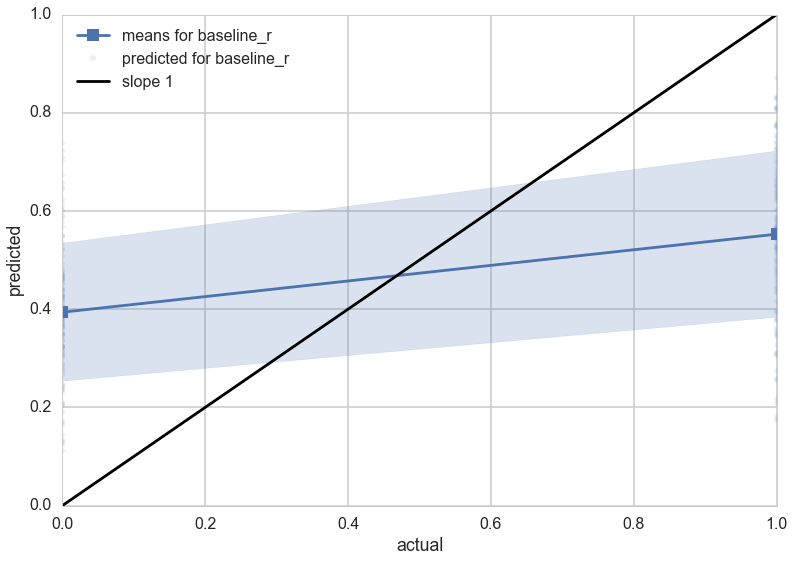

In [84]:
#your code here
predictions["baseline_r"]=clf.predict(testdf)
predictions_valid["baseline_r"]=clf.predict(valdf)
compare_results(Yresp_test,predictions['baseline_r'], model="baseline_r", predicteds=True)

## Q5 Combining results into an ensemble

From the Netflix Progress Prize 2007 paper (see http://brettb.net/project/papers/2007%20The%20BellKor%20solution%20to%20the%20Netflix%20prize.pdf):

>Predictive accuracy is substantially improved when blending multiple predictors. Our experience is that most efforts should be concentrated in deriving substantially different approaches, rather than refining a single technique. Consequently, our solution is an ensemble of many methods.
We approach blending as a linear regression problem. We ought to regress a target ratings vector on multiple predictors. The target rating vector can be the true ratings of the Probe set, and the predictors are the respective estimates for the Probe set by an ensemble of methods. The solution is the coefficients, or the weights, that should be given to each of the predictors in the ensemble.


Finally, we shall combine the ratings obtained from the kNN and the ALS approaches.

## What models have we collected so far?

In [90]:
predictions.keys()

['baseline_r', 'baseline_max', 'baseline_long']

In [92]:
#print get_rmse(atest, predictions['knn'])
#print get_rmse(atest, predictions['baseline_r'])
#print get_rmse(atest, predictions['svd'])
#print get_rmse(atest, predictions['baseline_long'])
#print get_rmse(atest, predictions['knn_r'])
#print get_rmse(atest, predictions['baseline_max'])

We construct a dataframe with the two predictions and the actual value on the **Validation** set.

In [ ]:
dfensemble=pd.DataFrame.from_dict({'knn_r':predictions_valid['knn_r'],
                                   'svd':predictions_valid['svd'], 
                                   'baseline_r':predictions_valid['baseline_r'], 'y':validatedf.stars.values})

#### 5.2 Carry out an unregularized linear regression of the actual values against the three predictions

Use the `y` values obtained from the validation set in the dataframe `dfensemble`. Regress against the other columns from the validation set. Such a regression is called 'stacking'. Store the regression model in the variable `valreg`

In [ ]:
#your code here
from sklearn.linear_model import LinearRegression
X = dfensemble.drop('y', axis = 1)
lm = LinearRegression()
valreg = lm.fit(X, dfensemble.y)

#### 5.3 Get the same models on the test set and use linear regression to calculate the predictions. Comment

 Store the predictions on the test set in the dataframe `dfensembletest` which should have columns exactly analogous to those on `dfensemble`. Use this dataframe in the prediction process on the test set. Store in the variable `epreds` the predictions of our stacked regression `valreg`, and the actual values of the ratings from the test set in the variable `testactual`. Comment on the results, using the diagram we plot below and the value of the RMSE as compared to before.

In [ ]:
#your code here
dfensembletest=pd.DataFrame.from_dict({'knn_r':predictions['knn_r'],
                                       'svd':predictions['svd'], 
                                       'baseline_r':predictions['baseline_r'], 'y':testdf.stars.values})

Xt = dfensembletest.drop('y', axis = 1)
epreds = valreg.predict(Xt)
testactual = testdf.stars.values

Lets plot the results and see the RMSE:

In [ ]:
ax=compare_results(testactual, epreds, model="ensemble", predicteds=True);

See http://web.stanford.edu/~lmackey/papers/netflix_story-nas11-slides.pdf for a fun presentation on Ensembling and the Netflix Prize. If you'd like to learn more, please read Chris Volinksy's papers on the Netflix prize. There are also comprehensive reviews [here](http://arxiv.org/abs/1202.1112) and [here](http://www.grouplens.org/system/files/FnT%20CF%20Recsys%20Survey.pdf).

FIN